## MLM Implementation
Folowing: https://huggingface.co/learn/nlp-course/chapter7/3?fw=tf


### Packages

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install -q transformers
!pip install pydot

# data processessing packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# NN Packages
import tensorflow as tf
from tensorflow import keras

# ML packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report

# NLP packages
from transformers import BertTokenizer,TFAutoModel, TFBertModel, BertForSequenceClassification,TFAutoModelForSequenceClassification


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 85.4 MB/s eta 0:00:00


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

### Global Variables

In [ ]:
target_names = ["Analyst Update","Fed | Central Banks",
        "Company | Product News","Treasuries | Corporate Debt",
        "Dividend","Earnings","Energy | Oil",
        "Financials","Currencies","General News | Opinion",
        "Gold | Metals | Materials","IPO","Legal | Regulation",
        "M&A | Investments","Macro","Markets","Politics",
        "Personnel Change","Stock Commentary", "Stock Movement"]

### Utility Functions

In [ ]:
#Function for creating tokenized data and outputs for models

def create_datasets(tokenizer, train, val, test):
  # Variables
  # train/val/test = datasets to encode
  # tokenizer = bert tokenizer

  train_encodings = tokenizer(list(train),padding=True, return_tensors='tf')
  valid_encodings = tokenizer(list(val),padding=True, return_tensors='tf')
  test_encodings = tokenizer(list(test),padding=True, return_tensors='tf')


  return train_encodings, valid_encodings, test_encodings


In [ ]:
 # Function for creating model
def create_bert_multiclass_model(model,
                                 num_classes,
                                 hidden_size = 201,
                                 dropout=0.3,
                                 learning_rate=0.00005,
                                 activation='softmax'):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """

    bert_model = model

    # building bert inputs
    input_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(None,), dtype=tf.int64, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    # building bert model
    bert_out = bert_model(bert_inputs)
    pooler_output = bert_out.pooler_output #bert_out[1]

    # building hidden layers
    last_hidden_output = tf.keras.layers.Dense(hidden_size, activation='relu', name='last_hidden_output')(pooler_output)
    last_hidden_output = tf.keras.layers.Dropout(dropout, name='dropout')(last_hidden_output)
    bert_cls_prediction = keras.layers.Dense(num_classes, activation=activation, name='cls_output')(last_hidden_output)

    # compiling model
    bert_cls_model = keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=bert_cls_prediction)
    bert_cls_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                           loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                           metrics='accuracy')

    ### END YOUR CODE
    return bert_cls_model

### Importing & Splitting Data

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/w266/data/clean_train_data.csv')
test_data = pd.read_csv('/content/drive/MyDrive/w266/data/clean_test_data.csv')

In [ ]:
# creating train/val datasets
x_train, x_val, y_train, y_val = train_test_split(train_data.text, train_data.label, test_size=0.20, random_state=42)
# creating test datasets
x_test = test_data.text
y_test = test_data.label

### BERT-Base

In [ ]:
# Loading BERT-base-MLM tokenizer/model
mlm_bert_tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/w266/Model-Weights/MLM/Bert-base-MLM-tokenizer')
mlm_bert_model = TFBertModel.from_pretrained("/content/drive/MyDrive/w266/Model-Weights/MLM/Bert-base-MLM")

Some layers from the model checkpoint at /content/drive/MyDrive/w266/Model-Weights/MLM/Bert-base-MLM were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at /content/drive/MyDrive/w266/Model-Weights/MLM/Bert-base-MLM and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Creating BERT-base-MLM encodings
mlm_bert_train_encodings, mlm_bert_valid_encodings, mlm_bert_test_encodings = create_datasets(mlm_bert_tokenizer, x_train, x_val, x_test)

In [ ]:
# Creating BERT-base-MLM model
bert_base_mlm = create_bert_multiclass_model(mlm_bert_model, num_classes=20)

In [ ]:
# Running BERT-base-MLM model
bert_cit_fit_model_history = bert_base_mlm.fit([mlm_bert_train_encodings.input_ids, mlm_bert_train_encodings.token_type_ids, mlm_bert_train_encodings.attention_mask],
                                                  y_train,
                                                  validation_data=([mlm_bert_valid_encodings.input_ids, mlm_bert_valid_encodings.token_type_ids, mlm_bert_valid_encodings.attention_mask],
                                                  y_val),
                                                  batch_size=8,
                                                  epochs=5)

Epoch 1/5
1699/1699 [==============================] - 141s 59ms/step - loss: 0.7892 - accuracy: 0.7783 - val_loss: 0.4405 - val_accuracy: 0.8714
Epoch 2/5
1699/1699 [==============================] - 74s 44ms/step - loss: 0.3440 - accuracy: 0.9036 - val_loss: 0.4255 - val_accuracy: 0.8799
Epoch 3/5
1699/1699 [==============================] - 73s 43ms/step - loss: 0.2255 - accuracy: 0.9380 - val_loss: 0.4680 - val_accuracy: 0.8802
Epoch 4/5
1699/1699 [==============================] - 72s 42ms/step - loss: 0.1675 - accuracy: 0.9547 - val_loss: 0.5188 - val_accuracy: 0.8826
Epoch 5/5
1699/1699 [==============================] - 73s 43ms/step - loss: 0.1330 - accuracy: 0.9637 - val_loss: 0.5262 - val_accuracy: 0.8838


In [ ]:
# Evaluating BERT-base-MLM models
bert_base_mlm_results = bert_base_mlm.evaluate([mlm_bert_test_encodings.input_ids, mlm_bert_test_encodings.token_type_ids, mlm_bert_test_encodings.attention_mask],
                                         y_test,
                                         batch_size=8)

print(f"Model accuracy: {bert_base_mlm_results[1]}\n"+
      f"Model loss: {bert_base_mlm_results[0]}")

515/515 [==============================] - 15s 24ms/step - loss: 0.5238 - accuracy: 0.8822
Model accuracy: 0.882195770740509
Model loss: 0.523804247379303


In [ ]:
# Computing BERT-base-MLM F1 metric
bert_mlm_y_pred = bert_base_mlm.predict([mlm_bert_test_encodings.input_ids, mlm_bert_test_encodings.token_type_ids, mlm_bert_test_encodings.attention_mask])
pred_bert_mlm_model = tf.argmax(bert_mlm_y_pred, axis=-1)

print(classification_report(y_test, pred_bert_mlm_model.numpy(), target_names=target_names, digits=4))



129/129 [==============================] - 6s 47ms/step
                             precision    recall  f1-score   support

             Analyst Update     1.0000    0.6027    0.7521        73
        Fed | Central Banks     0.8843    0.8925    0.8884       214
     Company | Product News     0.8771    0.9131    0.8948       852
Treasuries | Corporate Debt     0.9429    0.8571    0.8980        77
                   Dividend     0.9135    0.9794    0.9453        97
                   Earnings     0.9216    0.9711    0.9457       242
               Energy | Oil     0.8984    0.7877    0.8394       146
                 Financials     0.9062    0.9062    0.9062       160
                 Currencies     0.9091    0.9375    0.9231        32
     General News | Opinion     0.8047    0.8095    0.8071       336
  Gold | Metals | Materials     0.8000    0.9231    0.8571        13
                        IPO     0.7368    1.0000    0.8485        14
         Legal | Regulation     0.9135    0.79

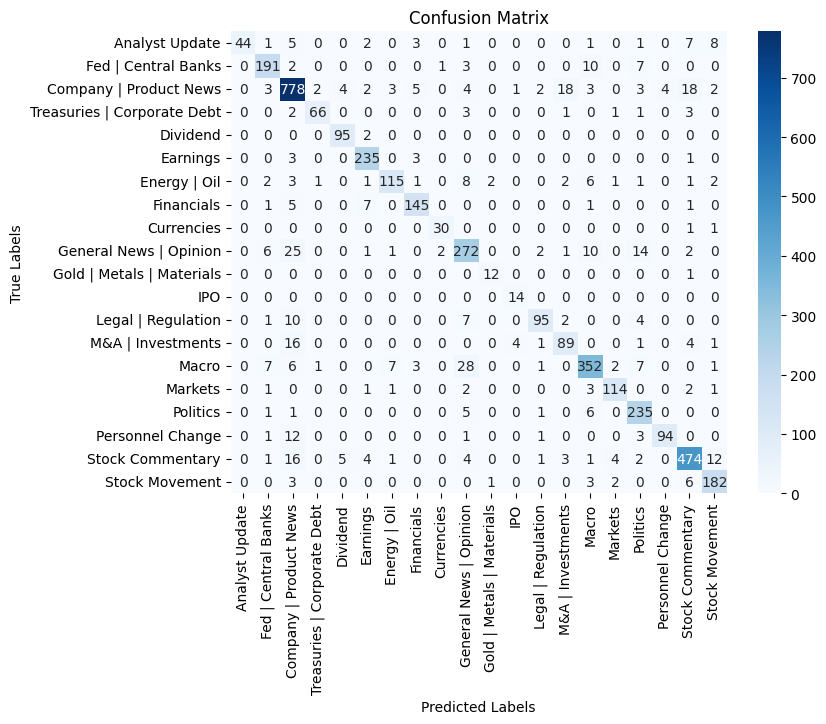

In [ ]:
bert_conf_matrix = confusion_matrix(y_test, pred_bert_mlm_model.numpy())

# Print the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(bert_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

### FinBert

In [ ]:
# Loading FinBert-MLM tokenizer/model
mlm_finbert_tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/w266/Model-Weights/MLM/FinBert-MLM-tokenizer')
mlm_finbert_model = TFBertModel.from_pretrained("/content/drive/MyDrive/w266/Model-Weights/MLM/FinBert-MLM")

Some layers from the model checkpoint at /content/drive/MyDrive/w266/Model-Weights/MLM/FinBert-MLM were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFBertModel were not initialized from the model checkpoint at /content/drive/MyDrive/w266/Model-Weights/MLM/FinBert-MLM and are newly initialized: ['bert/pooler/dense/bias:0', 'bert/pooler/dense/kernel:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Creating FinBert-MLM encodings
mlm_finbert_train_encodings, mlm_finbert_valid_encodings, mlm_finbert_test_encodings = create_datasets(mlm_finbert_tokenizer, x_train, x_val, x_test)

In [ ]:
# Creating FinBert-MLM model
finbert_mlm = create_bert_multiclass_model(mlm_finbert_model, num_classes=20)

In [ ]:
# Running FinBert-MLM model
bert_cit_fit_model_history = finbert_mlm.fit([mlm_finbert_train_encodings.input_ids, mlm_finbert_train_encodings.token_type_ids, mlm_finbert_train_encodings.attention_mask],
                                                  y_train,
                                                  validation_data=([mlm_finbert_valid_encodings.input_ids, mlm_finbert_valid_encodings.token_type_ids, mlm_finbert_valid_encodings.attention_mask],
                                                  y_val),
                                                  batch_size=8,
                                                  epochs=5)

Epoch 1/5
1699/1699 [==============================] - 137s 58ms/step - loss: 0.7434 - accuracy: 0.7843 - val_loss: 0.6121 - val_accuracy: 0.8231
Epoch 2/5
1699/1699 [==============================] - 73s 43ms/step - loss: 0.3302 - accuracy: 0.9068 - val_loss: 0.4550 - val_accuracy: 0.8785
Epoch 3/5
1699/1699 [==============================] - 75s 44ms/step - loss: 0.2114 - accuracy: 0.9400 - val_loss: 0.4443 - val_accuracy: 0.8879
Epoch 4/5
1699/1699 [==============================] - 73s 43ms/step - loss: 0.1690 - accuracy: 0.9531 - val_loss: 0.5465 - val_accuracy: 0.8855
Epoch 5/5
1699/1699 [==============================] - 73s 43ms/step - loss: 0.1403 - accuracy: 0.9615 - val_loss: 0.5077 - val_accuracy: 0.8905


In [ ]:
# Evaluating FinBert-MLM models
finbert_mlm_results = finbert_mlm.evaluate([mlm_finbert_test_encodings.input_ids, mlm_finbert_test_encodings.token_type_ids, mlm_finbert_test_encodings.attention_mask],
                                         y_test,
                                         batch_size=8)

print(f"Model accuracy: {finbert_mlm_results[1]}\n"+
      f"Model loss: {finbert_mlm_results[0]}")

515/515 [==============================] - 15s 24ms/step - loss: 0.5495 - accuracy: 0.8817
Model accuracy: 0.8817099928855896
Model loss: 0.5494968295097351


In [ ]:
# Computing FinBert-MLM F1 metric
finbert_mlm_y_pred = finbert_mlm.predict([mlm_finbert_test_encodings.input_ids, mlm_finbert_test_encodings.token_type_ids, mlm_finbert_test_encodings.attention_mask])
pred_finbert_mlm_model = tf.argmax(finbert_mlm_y_pred, axis=-1)

print(classification_report(y_test, pred_finbert_mlm_model.numpy(), target_names=target_names, digits=4))



129/129 [==============================] - 8s 37ms/step
                             precision    recall  f1-score   support

             Analyst Update     0.9483    0.7534    0.8397        73
        Fed | Central Banks     0.9220    0.8832    0.9021       214
     Company | Product News     0.8680    0.9261    0.8961       852
Treasuries | Corporate Debt     0.9014    0.8312    0.8649        77
                   Dividend     0.9789    0.9588    0.9688        97
                   Earnings     0.9744    0.9421    0.9580       242
               Energy | Oil     0.9161    0.8973    0.9066       146
                 Financials     0.8041    0.9750    0.8814       160
                 Currencies     0.7209    0.9688    0.8267        32
     General News | Opinion     0.7982    0.7768    0.7873       336
  Gold | Metals | Materials     0.5652    1.0000    0.7222        13
                        IPO     0.9231    0.8571    0.8889        14
         Legal | Regulation     0.9192    0.76

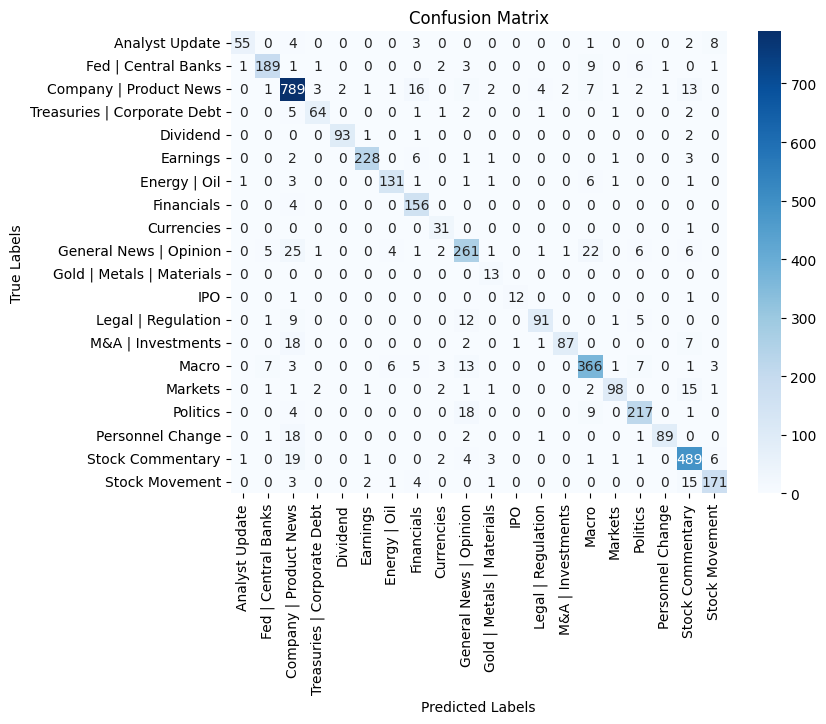

In [ ]:
finbert_conf_matrix = confusion_matrix(y_test, pred_finbert_mlm_model.numpy())

# Print the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(finbert_conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

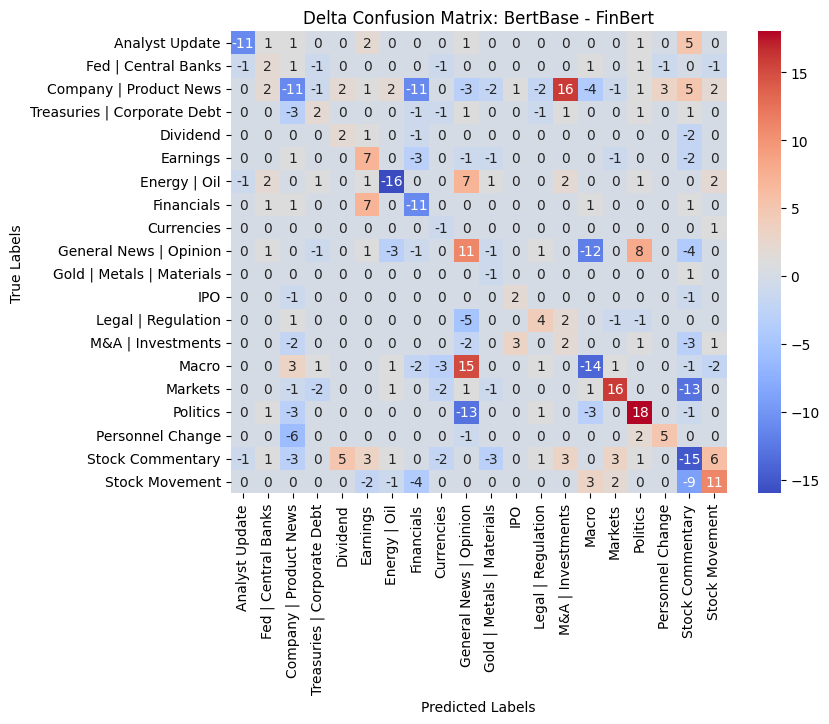

In [ ]:
# Calculate the difference between the two confusion matrices
delta_cm = bert_conf_matrix - finbert_conf_matrix

# Print the Delta Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(delta_cm, annot=True, fmt="d", cmap="coolwarm", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Delta Confusion Matrix: BertBase - FinBert")
plt.show()